Author: Guilherme Rosa Franzini (15/5/2024) - email:gfranzini@usp.br

Firstly, we define the packages we need for the script. Here, we will use DifferentialEquations (for solving the ODE and for using event handling commands), CairoMakie for plotting and LaTeXStrings for nice labels.

In [1]:
using DifferentialEquations
using CairoMakie
using LaTeXStrings

This is our problem: We need to find the numerical solution of $\ddot{y}+2\xi \omega \dot{y}+\omega^2 y = 0$. Even though this is simple, we need to terminate the numerical integration after 8 intersections of the flow with the following Poincaré section: $\Sigma = \lbrace (y,\dot{y}) \in ℝ^2 : \dot{y}=0,\ddot{y}<0 \rbrace$. It is clear that this section computes local maxima of $y(t)$. As usual, the following change of variables is needed: $u_1=y$ and $u_2=\dot{y}$. With this, the second-order ODE becomes a system of first-order ODEs as follows:

\begin{align}
&\dot{u}_1=u_2\\
&\dot{u}_2=-2\xi \omega u_2 - \omega ^2 u_1
\end{align}

Firstly we define the first-order system of ODEs, parametrized by $p$. Notice that $p$ gathers not only parameters of the mathematical model but also information regarding the number of times that the flow crosses the Poincaré section (number of times that the event is observed), the total number of events that we need to simulate and the time instants that the event occurred. You can find more details on how to use event handling commands here: https://docs.sciml.ai/DiffEqDocs/stable/features/callback_functions/

In [2]:
function my_diffeq!(du, u, p, t)
	ξ, ω, event_num, event_tot = p
	du[1] = u[2]
	du[2] = -ω^2 * u[1] - 2 * ξ * ω * u[2]
end
function condition(u, t, integrator)
	# First condition function 
	-u[2]  # Trigger when x crosses 0 in downward direction. Remove sign "-" if you want to compute upwards.
end

function affect!(integrator)
	# extract counter from the "cache"
	integrator.p[3] += 1 # update crossing amount
	integrator.p[5] = push!(integrator.p[5], integrator.t)

	println(string("This is the event number ", integrator.p[3]))
	println(string("Event occurred at ", integrator.t))

	# if crossings = n_crossings, terminate, else nothing
	integrator.p[3] == integrator.p[4] ? terminate!(integrator) : nothing
end


affect! (generic function with 1 method)

Now, we run the model, using the callback function we defined above, together with the affect command that is triggered when the event is observed. We consider $\xi=0.01$, $\omega=1$ and we would like to compute 8 intersections with the Poincaré section. Notice that we consider the maximum simulated time $t_{max}=100$, but the simulation will terminate at 8 intersections.

In [3]:
u0 = [1.0, 0.0] # Initial conditions 
ξ = 0.01
ω = 1
event_num = 0
event_tot = 8
tcond = Float64[]
p = [ξ, ω, event_num, event_tot, tcond]
tspan = (0.0, 100.0) # Time span 

prob = ODEProblem(my_diffeq!, u0, tspan, p)

cb = ContinuousCallback(condition, affect!; affect_neg! = nothing) #use this command if you would like to compute the single-sided Poincaré section

#cb = ContinuousCallback(condition, affect!) #use this command if you would like to compute the two-sided Poincaré section

# Integrate using Tsis5() algorithm, with event handling 
sol = solve(prob, Tsit5(), callback = cb)


┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase /Users/gfranzini/.julia/packages/SciMLBase/JUp1I/src/performance_warnings.jl:33


This is the event number 1
Event occurred at 6.28342056213562
This is the event number 2
Event occurred at 12.566606678749174
This is the event number 3
Event occurred at 18.849635739173173
This is the event number 4
Event occurred at 25.132575875197332
This is the event number 5
Event occurred at 31.415515824262034
This is the event number 6
Event occurred at 37.69845616479983
This is the event number 7
Event occurred at 43.98139644596371
This is the event number 8
Event occurred at 50.264336679916454


retcode: Terminated
Interpolation: specialized 4th order "free" interpolation
t: 81-element Vector{Float64}:
  0.0
  0.0009990009990009992
  0.010989010989010992
  0.07986830308224022
  0.24039627115787773
  0.48126399386111407
  0.7874531670742837
  1.177508897302658
  1.63037884475052
  2.10439703388506
  ⋮
 44.88441844671795
 45.779237902136956
 46.66597994759569
 47.558007961795845
 48.3830556211846
 49.29098586035955
 50.107701019869914
 50.264336679916454
 50.264336679916454
u: 81-element Vector{Vector{Float64}}:
 [1.0, 0.0]
 [0.9999995010018669, -0.0009989908528715088]
 [0.9999396258494336, -0.01098758235032446]
 [0.9968139186637707, -0.07971972982256824]
 [0.971289689342237, -0.23751608495132123]
 [0.8867726693535691, -0.46067935669343724]
 [0.7071750135623286, -0.7030083494936041]
 [0.3879228703190856, -0.9128652873375388]
 [-0.04868410105877144, -0.9821361909496394]
 [-0.48952664720125844, -0.8431451366027115]
 ⋮
 [0.4011491408645447, -0.5023631449046218]
 [-0.136602758457685

Now, we plot $y(t)$ and $\dot{y}(t)$ (or $u_1(t)$ and $u_2(t)$), and the points on the defined Poincaré section (crosses). We also plot the phase-space.

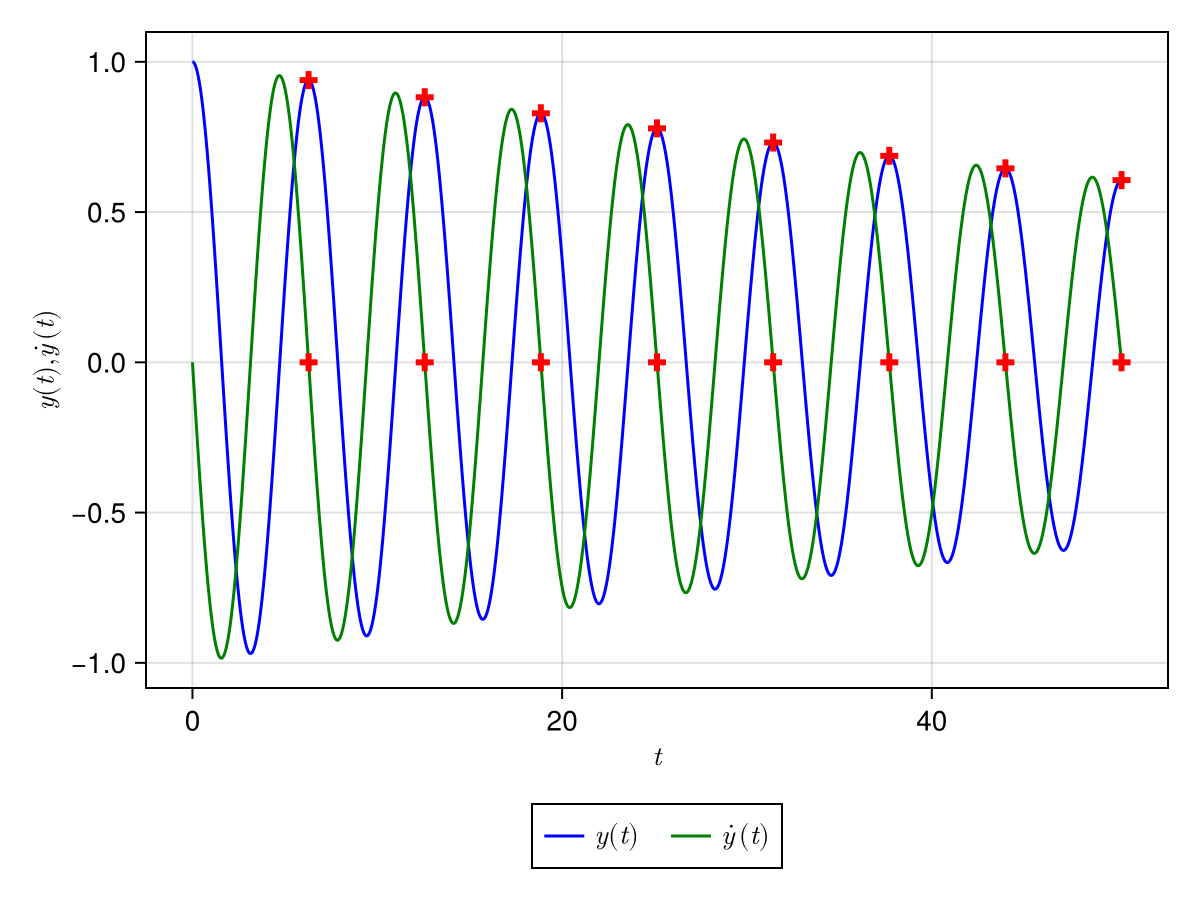

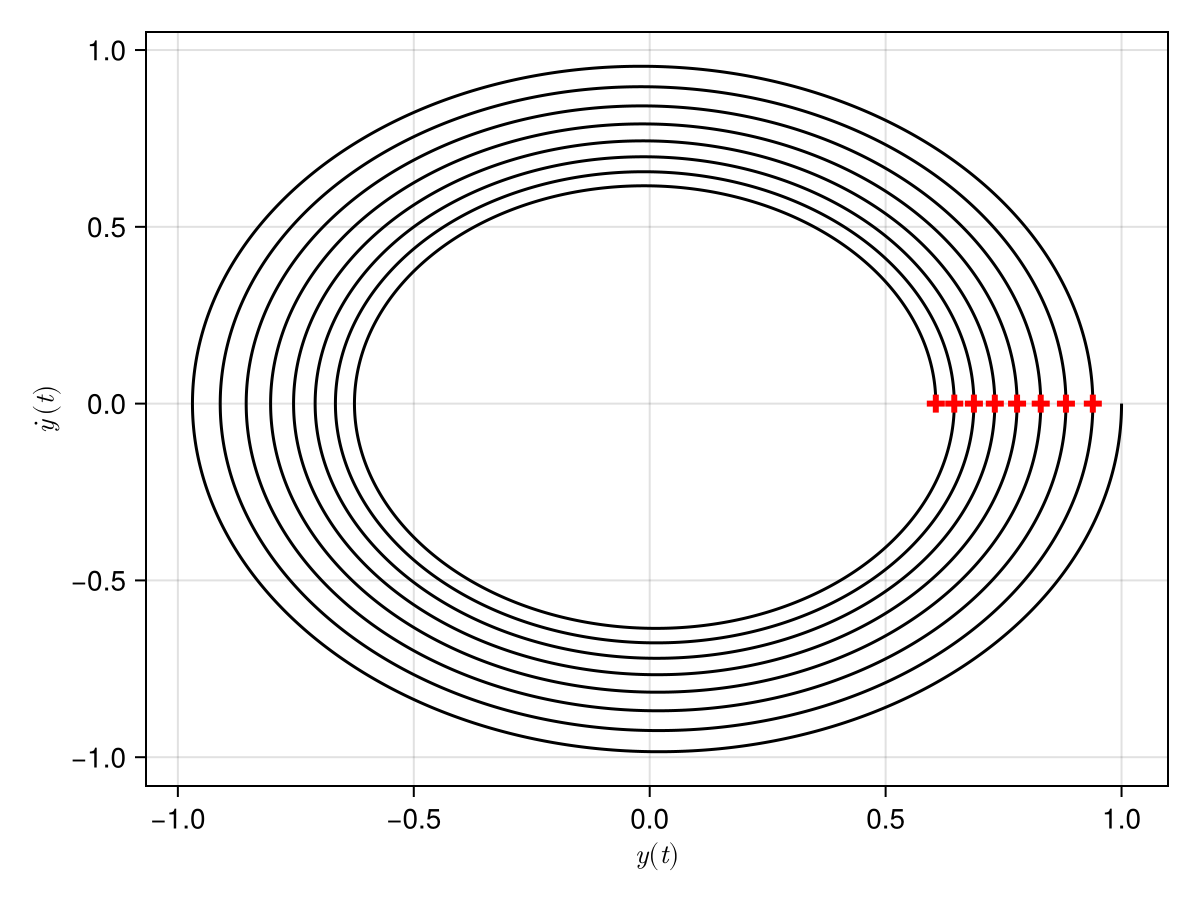

CairoMakie.Screen{IMAGE}


In [4]:
ts = 0:0.01:sol.t[end]
solu = sol(ts)
tevent = p[5]
solevent = Array(sol(tevent))
Fig = Figure()
ax = Axis(Fig[1, 1], xlabel = L"t", ylabel = L"y(t),\dot{y}(t)", xlabelsize = 14, ylabelsize = 14)
lines!(ax, ts, solu[1, :], label = L"y(t)", color = :blue)
lines!(ax, ts, solu[2, :], label = L"\dot{y}(t)", color = :green)
scatter!(ax, tevent, solevent[1, :], marker = :cross, color = :red, markersize = 12)
scatter!(ax, tevent, solevent[2, :], marker = :cross, color = :red, markersize = 12)
Legend(Fig[2, 1], ax, orientation = :horizontal)
display(Fig)

Fig2 = Figure()
ax2 = Axis(Fig2[1, 1], xlabel = L"y(t)", ylabel = L"\dot{y}(t)", xlabelsize = 14, ylabelsize = 14)
lines!(ax2, solu[1, :], solu[2, :], color = :black)
scatter!(ax2, solevent[1, :], solevent[2, :], marker = :cross, color = :red, markersize = 12)
display(Fig2)
